# Mohamaco – Model & Analysis Generator

**Goal:** Build a consolidated dataset across all weeks (versions), compute **indicators** and **real staff costs**, export `model_data.json`, and show quick sanity plots.

**Outputs**
- `model_data.json` — one record per (version, product) with indicators
- Quick preview plots for volume & revenue (no decisions here)

**Data inputs**  
`data/amounts/amounts_v.json`, `data/prices/prices_v.json`,  
`data/transactions/transactions_v.json`, `data/supplier_prices.json`,  
`data/schedules/schedules_v.json`, `data/workers/workers.jsonl`.

**Role of GPT (GPT-5):** data pipelining, robust parsing, indicators, staff-cost logic, concise visuals/documentation.

In [1]:
# === Load & Merge ============================================================
# Load all relevant datasets (amounts, prices, transactions, supplier prices, workers)
# Detect available versions automatically and merge into a unified DataFrame.

import json, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use("ggplot")   # Apply ggplot style for plots

# Base data directory structure
DATA_DIR = Path("data")
AMOUNTS_DIR = DATA_DIR/"amounts"
PRICES_DIR = DATA_DIR/"prices"
TRANSACTIONS_DIR = DATA_DIR/"transactions"
SUPPLIER_PATH = DATA_DIR/"supplier_prices.json"
SCHEDULES_DIR = DATA_DIR/"schedules"
WORKERS_PATH = DATA_DIR/"workers"/"workers.jsonl"

def read_json(p): 
    """Read a JSON file and return its content."""
    with open(p,"r",encoding="utf-8") as f: 
        return json.load(f)

def read_jsonl(p):
    """Read .jsonl file (one JSON object per line) and return DataFrame."""
    rows=[]
    with open(p,"r",encoding="utf-8-sig") as f:
        for line in f:
            line=line.strip()
            if line:
                rows.append(json.loads(line))
    return pd.DataFrame(rows)

def detect_versions():
    """Detect available version numbers (files named ..._X.json)."""
    vs=set()
    for d in (AMOUNTS_DIR, PRICES_DIR, TRANSACTIONS_DIR, SCHEDULES_DIR):
        if not d.exists(): 
            continue
        for f in d.glob("*_[0-9].json"):
            try:
                vs.add(int(f.stem.split("_")[-1]))  # Extract version number
            except:
                pass
    return sorted(vs)

VERSIONS = detect_versions()
print("Detected versions:", VERSIONS)

# Load supplier prices into DataFrame
supplier = pd.DataFrame(list(read_json(SUPPLIER_PATH).items()), 
                        columns=["product","supplier_price"])

def load_amounts_prices(v):
    """Load product amounts and prices for a given version and merge into one DataFrame."""
    a = read_json(AMOUNTS_DIR/f"amounts_{v}.json")
    p = read_json(PRICES_DIR/f"prices_{v}.json")
    A = pd.DataFrame(list(a.items()), columns=["product","amount"])
    P = pd.DataFrame(list(p.items()), columns=["product","price"])
    return A.merge(P, on="product", how="outer").assign(version=v)

def load_transactions(v):
    """Explode transactions JSON into rows: one row per product occurrence."""
    raw = read_json(TRANSACTIONS_DIR/f"transactions_{v}.json")
    rows=[]
    for _, txs in raw.items():
        for tx in txs:
            types, amts = tx.get("merch_types", []), tx.get("merch_amounts", [])
            for t, a in zip(types, amts):
                rows.append({"product":str(t), "qty":float(a), "version":v})
    return pd.DataFrame(rows)

# Load product master data (amounts + prices) and merge per version
products = pd.concat([load_amounts_prices(v) for v in VERSIONS], ignore_index=True)

# Load transactions if the version exists
transactions = pd.concat(
    [load_transactions(v) for v in VERSIONS if (TRANSACTIONS_DIR/f"transactions_{v}.json").exists()],
    ignore_index=True
)

# Merge: products ⟶ aggregated transactions ⟶ supplier prices
df = (products
      .merge(transactions.groupby(["version","product"])["qty"].sum().reset_index(),
             on=["version","product"], how="left")
      .merge(supplier, on="product", how="left"))

df["qty"] = df["qty"].fillna(0.0)  # No sales → quantity = 0

# Derived metrics
df["revenue"] = df["qty"] * df["price"]
df["product_cost"] = df["qty"] * df["supplier_price"]
df["gross_profit"] = df["revenue"] - df["product_cost"]

print(f"Rows: {len(df)}, Products: {df['product'].nunique()}")
display(df.head())

Detected versions: [0, 1, 2, 3, 4, 5, 6, 7]
Rows: 104, Products: 13


,product,amount,price,version,qty,supplier_price,revenue,product_cost,gross_profit
0,batteries,2096,15.85,0,2096.0,12.0,33221.60,25152.0,8069.60
1,dinosaur,1947,94.60,0,0.0,65.0,0.00,0.0,0.00
2,gjokur_ja,69,814.31,0,69.0,580.0,56187.39,40020.0,16167.39
3,hammer,2556,59.08,0,2556.0,45.0,151008.48,115020.0,35988.48
4,hot_dogs,2240,26.25,0,2240.0,18.0,58800.00,40320.0,18480.00


In [2]:
# === Staff Costs from workers × schedules ===================================
# This section links workers with scheduled shifts and calculates staff cost.

def flatten_schedule(v):
    """Load schedule_v.json and flatten into a DataFrame (one row per worker shift)."""
    p = SCHEDULES_DIR/f"schedules_{v}.json"
    if not p.exists():
        # Return empty DataFrame with expected columns
        return pd.DataFrame(columns=["version","day","worker_id","department","shift"])

    raw = read_json(p)
    rows=[]
    for day, entries in raw.items():       # each key = weekday
        for e in entries:                  # each entry = worker assignment
            r = {"version": v, "day": day, **e}
            rows.append(r)

    dfv = pd.DataFrame(rows)

    # Ensure correct worker_id column name (in case JSON used a different name)
    if "worker_id" not in dfv.columns:
        alt = [c for c in dfv.columns if "worker" in c and "id" in c]
        if alt:
            dfv = dfv.rename(columns={alt[0]: "worker_id"})

    dfv["worker_id"] = dfv["worker_id"].astype(str)
    return dfv


# Load workers table (workers.jsonl)
workers = read_jsonl(WORKERS_PATH)

# Normalize worker_id column if needed
if "worker_id" not in workers.columns:
    alt = [c for c in workers.columns if "worker" in c and "id" in c]
    if alt:
        workers = workers.rename(columns={alt[0]: "worker_id"})

workers["worker_id"] = workers["worker_id"].astype(str)
workers["salary"] = pd.to_numeric(workers.get("salary", np.nan), errors="coerce")

# Flatten all schedules across versions
schedules_all = pd.concat([flatten_schedule(v) for v in VERSIONS], ignore_index=True)

def shift_mult(x):
    """Convert shift index to multiplier (safety: defaults to 1.0)."""
    try:
        x = float(x)
        return x if x > 0 else 1.0
    except:
        return 1.0

# Assign multiplier per shift (e.g., shift 2 costs more than shift 1)
schedules_all["shift_mult"] = schedules_all["shift"].apply(shift_mult) if "shift" in schedules_all else 1.0


# Determine salary per shift:
# Reference version = second-to-last version (most recent before current)
ref_v = VERSIONS[-2] if len(VERSIONS) >= 2 else VERSIONS[0]

# Count how many shifts each worker worked in the reference version
shifts_ref = (
    schedules_all[schedules_all["version"] == ref_v]
    .groupby("worker_id")["shift_mult"].sum()
    .rename("shifts_ref")
)

workers = workers.merge(shifts_ref, on="worker_id", how="left").fillna({"shifts_ref": 1.0})

# Calculate per-shift cost = salary / number of shifts worked in reference week
workers["per_shift_cost"] = workers["salary"] / workers["shifts_ref"]

# Assign shift cost into schedule entries
schedules_all = schedules_all.merge(workers[["worker_id","per_shift_cost"]], on="worker_id", how="left")
schedules_all["entry_cost"] = schedules_all["per_shift_cost"].fillna(0.0) * schedules_all["shift_mult"].astype(float)

# Aggregate cost per version
staff_cost_by_version = schedules_all.groupby("version")["entry_cost"].sum().to_dict()

print("staff_cost_by_version:", {int(k): round(float(v), 2) for k, v in staff_cost_by_version.items()})

staff_cost_by_version: {0: 194596.34, 1: 194596.34, 2: 194596.34, 3: 194596.34, 4: 194596.34, 5: 194596.34, 6: 194596.34, 7: 181976.14}


In [3]:
# === Indicators & Export (with Time-Adjusted Sell-Through) ===================
# Computes product performance indicators per version and exports them.

def safe_div(a, b):
    """Safe division: returns 0 where denominator is 0."""
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

D_TOTAL = 7  # total selling days per week (used for stockout timing estimation)


# --- Helper: Estimate day of stockout (heuristic) ----------------------------
def estimate_Dout(st):
    """
    Estimate the stockout day (1..7) based on sell-through level.
    Rules:
    - sell_through < 0.9 → product did not sell out (D_out = 8)
    - 0.9 ≤ ST ≤ 1.0 → interpolate between day 6 (slow sellout) and day 3 (fast sellout)
    - ST > 1.0 → over-demand situation → assume very early sellout (day ≈ 2)
    """
    if st < 0.9:
        return D_TOTAL + 1       # did not sell out within week
    elif st <= 1.0:
        # linear interpolation: higher sell-through → earlier sold out
        return np.interp(st, [0.9, 1.0], [6.0, 3.0])
    else:
        # heavy over-demand: sold out very early
        return 2.0


# --- Compute all indicators --------------------------------------------------
ind_list = []
for v in VERSIONS:
    d = df[df["version"] == v].copy()

    # Core product performance ratios
    d["sell_through"]          = safe_div(d["qty"], d["amount"])
    d["price_cost_ratio"]      = safe_div(d["price"], d["supplier_price"])
    d["gross_margin_%"]        = safe_div(d["price"] - d["supplier_price"], d["price"]) * 100
    d["profit_per_stock_unit"] = safe_div(d["gross_profit"], d["amount"])
    d["demand_supply_index"]   = d["sell_through"] * d["price_cost_ratio"]

    # --- Time-adjusted sell-through (TAST) -----------------------------------
    # Estimate when the item sold out (if at all)
    d["D_out_est"] = d["sell_through"].apply(estimate_Dout)

    # Normalized score 0–1:
    # If product sells out early, score increases; if it never sells out, score decreases.
    d["TAST_norm"] = np.minimum(
        1.0, d["sell_through"] * (D_TOTAL + 1) / d["D_out_est"]
    )

    # Staff cost allocation (same for all products in the version)
    d["version_staff_cost"] = staff_cost_by_version.get(v, 0.0)

    # Profit efficiency: total profit per worker payroll spent
    d["profit_per_worker"] = safe_div(d["gross_profit"], d["version_staff_cost"])

    ind_list.append(d)


# --- Combine all versions ----------------------------------------------------
df_ind = pd.concat(ind_list, ignore_index=True)


# --- Diagnostics -------------------------------------------------------------
print(f"Indicators computed for {len(VERSIONS)} versions ({len(df_ind)} rows)")
display(
    df_ind[["version", "product", "sell_through", "TAST_norm", "price_cost_ratio", "gross_margin_%"]]
    .head(10)
)


# --- Export to model_data.json ----------------------------------------------
OUT = Path("model_data.json")
with open(OUT, "w", encoding="utf-8") as f:
    json.dump(df_ind.to_dict(orient="records"), f, indent=2, ensure_ascii=False)

print(f"Exported: {OUT} ({len(df_ind)} rows, {df_ind['product'].nunique()} products)")

Indicators computed for 8 versions (104 rows)


,version,product,sell_through,TAST_norm,price_cost_ratio,gross_margin_%
0,0,batteries,1.000000,1.000000,1.320833,24.290221
1,0,dinosaur,0.000000,0.000000,1.455385,31.289641
2,0,gjokur_ja,1.000000,1.000000,1.403983,28.774054
3,0,hammer,1.000000,1.000000,1.312889,23.832092
4,0,hot_dogs,1.000000,1.000000,1.458333,31.428571
5,0,ice_cream,0.737698,0.737698,1.481250,32.489451
6,0,knives,0.166720,0.166720,1.438158,30.466606
7,0,laderhosen,0.084262,0.084262,1.440818,30.594990
8,0,mattress,1.000000,1.000000,1.329786,24.799914
9,0,monster,0.848434,0.848434,1.411875,29.172200


Exported: model_data.json (104 rows, 13 products)


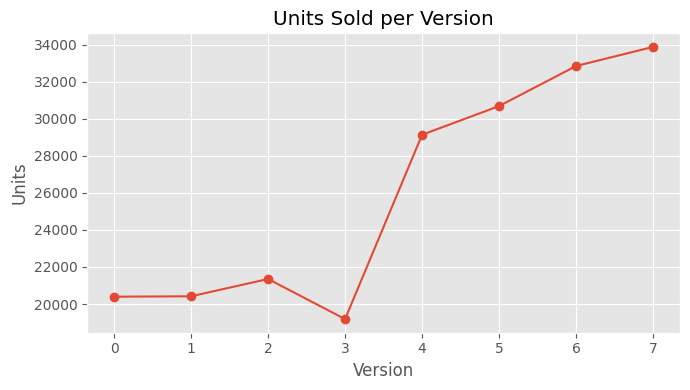

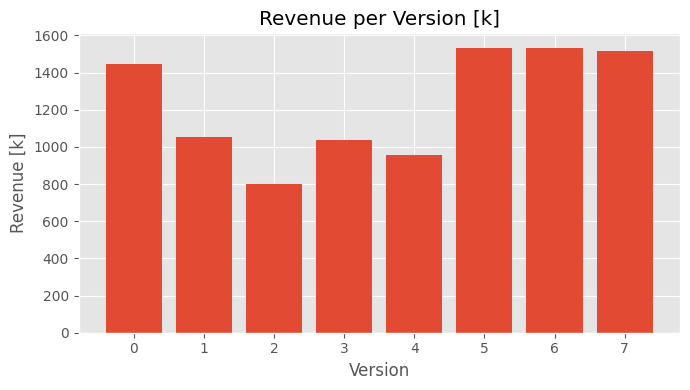

In [4]:
# === Quick sanity plots (volume & revenue) ===================================
# Basic validation plots: total units sold and total revenue per version.

# Aggregate total sold units and revenue per version
sumv = df_ind.groupby("version")[["qty", "revenue"]].sum().reset_index()

# Plot total units sold per version
plt.figure(figsize=(7, 4))
plt.plot(sumv["version"], sumv["qty"], marker="o")
plt.title("Units Sold per Version")
plt.xlabel("Version")
plt.ylabel("Units")
plt.tight_layout()
plt.show()

# Plot total revenue per version (in thousands)
plt.figure(figsize=(7, 4))
plt.bar(sumv["version"], sumv["revenue"] / 1000)
plt.title("Revenue per Version [k]")
plt.xlabel("Version")
plt.ylabel("Revenue [k]")
plt.tight_layout()
plt.show()

In [5]:
# === Finalize model_data.json: salvage-aware profits + corrected product_cost ===
# Adjust profit calculation to include salvage value of unsold inventory.
# Overwrites product_cost, gross_profit, net_profit while preserving legacy fields.

SALVAGE_RATE = 0.25  # % of supplier cost recovered when unsold stock is salvaged (rescued value)

# Load exported model data + supplier prices
data = json.loads(OUT.read_text(encoding="utf-8"))
supplier = json.loads(SUPPLIER_PATH.read_text(encoding="utf-8"))

def get_units_sold(rec):
    """
    Determine units sold from available fields in the record.
    Priority: explicit keys (units_sold / qty / quantity / sold)
    Fallback: use sell_through * amount
    """
    for k in ("units_sold", "qty", "quantity", "sold"):
        v = rec.get(k)
        if v is not None:
            try:
                return float(v)
            except:
                pass

    # Fallback: derive from sell-through ratio
    st = float(rec.get("sell_through", 0.0) or 0.0)
    amt = float(rec.get("amount", 0.0) or 0.0)
    return st * amt


# Iterate through each record and recompute salvage-aware profitability
for r in data:

    p = r.get("product")
    if not p:
        continue  # skip incomplete entries

    # Determine supplier price (prioritize supplier file, fallback to stored value)
    sp = float(supplier.get(p, r.get("supplier_price", 0.0)) or 0.0)

    amt = float(r.get("amount", 0.0) or 0.0)   # total units available
    prc = float(r.get("price", 0.0) or 0.0)    # actual retail price

    sold = get_units_sold(r)         # units sold
    left = max(0.0, amt - sold)      # remaining unsold inventory

    # Compute cost and revenue components
    purchase_cost = amt * sp         # cost to acquire inventory
    sales_revenue = sold * prc       # revenue from sold units
    salvage_value = left * sp * SALVAGE_RATE  # salvage value for unsold units

    gross_profit_salvage = sales_revenue + salvage_value - purchase_cost

    # Optional: subtract labor/staffing cost if available on record
    staff_cost = None
    for k in ("version_staff_cost", "staff_cost", "labor_cost"):
        if r.get(k) is not None:
            try:
                staff_cost = float(r[k])
                break
            except:
                pass

    net_profit_salvage = gross_profit_salvage - (staff_cost or 0.0)

    # Preserve legacy values to avoid loss of original computation
    r["legacy_product_cost"] = r.get("product_cost")
    r["legacy_gross_profit"] = r.get("gross_profit")

    # Overwrite with corrected + salvage-aware values
    r["supplier_price"] = sp
    r["product_cost"]   = float(purchase_cost)
    r["sales_revenue"]  = float(sales_revenue)
    r["salvage_rate"]   = SALVAGE_RATE
    r["salvage_value"]  = float(salvage_value)
    r["gross_profit"]   = float(gross_profit_salvage)
    r["net_profit"]     = float(net_profit_salvage)


# Save updated model file
OUT.write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")
print("model_data.json updated: product_cost fixed and profits are salvage-aware.")

model_data.json updated: product_cost fixed and profits are salvage-aware.
